In [1]:
import os
os.chdir('../')
from DeepPurpose import dataset

import numpy as np
import pandas as pd

RDKit WARNING: [21:35:02] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
SMILES, Target_seq, y = dataset.load_process_DAVIS()

Beginning Processing...
Beginning to extract zip file...
Default set to logspace (nM -> p) for easier regression
Done!


In [16]:
X_drug, X_target, y  = dataset.process_BindingDB('../data/BindingDB_All.tsv',
                                         y = 'Kd', 
                                         binary = False, 
                                         convert_to_log = True)

Loading Dataset from path...


b'Skipping line 772572: expected 193 fields, saw 205\nSkipping line 772598: expected 193 fields, saw 205\n'
b'Skipping line 805291: expected 193 fields, saw 205\n'
b'Skipping line 827961: expected 193 fields, saw 265\n'
b'Skipping line 1231688: expected 193 fields, saw 241\n'
b'Skipping line 1345591: expected 193 fields, saw 241\nSkipping line 1345592: expected 193 fields, saw 241\nSkipping line 1345593: expected 193 fields, saw 241\nSkipping line 1345594: expected 193 fields, saw 241\nSkipping line 1345595: expected 193 fields, saw 241\nSkipping line 1345596: expected 193 fields, saw 241\nSkipping line 1345597: expected 193 fields, saw 241\nSkipping line 1345598: expected 193 fields, saw 241\nSkipping line 1345599: expected 193 fields, saw 241\n'
b'Skipping line 1358864: expected 193 fields, saw 205\n'
b'Skipping line 1378087: expected 193 fields, saw 241\nSkipping line 1378088: expected 193 fields, saw 241\nSkipping line 1378089: expected 193 fields, saw 241\nSkipping line 1378090: e

Beginning Processing...
There are 66444 drug target pairs.
Default set to logspace (nM -> p) for easier regression


In [22]:
x = [i for i in np.unique(SMILES) if i in np.unique(X_drug)]

In [24]:
len(x)

0

## This means DAVIS and our pretrained dataset is not overlapped. 

In [4]:
df_data = pd.DataFrame(zip(SMILES, Target_seq, y))
df_data.rename(columns={0:'SMILES',
                        1: 'Target Sequence',
                        2: 'Label'}, 
                        inplace=True)

In [5]:
df_1000 = df_data.sample(n = 1000, replace = False).reset_index(drop = True)

In [6]:
from DeepPurpose import oneliner
oneliner.virtual_screening(df_1000['Target Sequence'].values, target_name = None, 
                X_repurpose = df_1000['SMILES'].values, 
                drug_names = None,
                save_dir = './save_folder',               
                pretrained_dir = './save_folder/pretrained_models/DeepPurpose_BindingDB/',
                convert_y = True,
                subsample_frac = 1,
                pretrained = True,
                split = 'random',
                frac = [0.7,0.1,0.2],
                agg = 'agg_mean_max',
                output_len = 30)


Loading customized repurposing dataset...
Checking if pretrained directory is valid...
Beginning to load the pretrained models...
Using pretrained model and making predictions...
virtual screening...
in total: 1000 drug-target pairs
encoding drug...
unique drugs: 68
drug encoding finished...
encoding protein...
unique target sequence: 342
protein encoding finished...
Done.
predicting...
---------------
Predictions from model 1 with drug encoding MPNN and target encoding CNN are done...
-------------
virtual screening...
in total: 1000 drug-target pairs
encoding drug...
unique drugs: 68
drug encoding finished...
encoding protein...
unique target sequence: 342
protein encoding finished...
Done.
predicting...
---------------
Predictions from model 2 with drug encoding CNN and target encoding CNN are done...
-------------
virtual screening...
in total: 1000 drug-target pairs
encoding drug...
unique drugs: 68
drug encoding finished...
encoding protein...
unique target sequence: 342
protein 

In [7]:
import pickle
from utils import convert_y_unit
with open('./save_folder/results_aggregation/logits_VS_mean_max.pkl', 'rb') as f:
    list_ = pickle.load(f)
result = convert_y_unit(list_, 'nM', 'p')
from scipy.stats import pearsonr

pearsonr(result, df_1000.Label.values)

(0.7789033207464225, 1.918887820416166e-204)

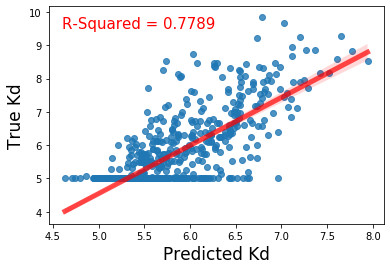

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
fontsize = 17

sns.regplot(x=result, y=df_1000.Label.values, line_kws={"color":"r","alpha":0.7,"lw":5})
plt.xlabel('Predicted Kd', fontsize = fontsize)
plt.ylabel('True Kd', fontsize = fontsize)
plt.text(4.6, 9.5, "R-Squared = 0.7789", horizontalalignment='left', size='medium', color='red', fontsize = 15)
plt.savefig('./correlation.pdf')